In [1]:
# -*- coding: utf-8 -*-
"""Trains a convolutional neural network on the MNIST dataset, then attacks it with the FGSM attack."""
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np

from art.attacks.evasion import ElasticNet
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("mnist"))

# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

# Evaluate the classifier on the test set
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))

# Define epsilon values
epsilon_values = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Iterate over epsilon values
    # Craft adversarial samples with FGSM
adv_crafter = ElasticNet(classifier, verbose = False)
x_test_adv = adv_crafter.generate(x=x_test, y=y_test)

# Evaluate the classifier on the adversarial examples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Test accuracy on adversarial sample (epsilon = %.2f): %.2f%%" % (epsilon, acc * 100))

y_hat = preds
y_test_arg = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_arg, y_hat)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test_arg, y_hat, average='macro')
accuracy = accuracy_score(y_test_arg, y_hat)
f1 = f1_score(y_test_arg, y_hat, average='weighted')
# auc = roc_auc_score(y_test_arg, cnn_model.predict(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
# print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

metrics = {
    "model" : "cnn",
    "attack_model" : "fgsm",
    "epsilon" : epsilon,
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    # "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/MNIST/model.csv", mode='a', index=False)


2024-02-13 09:41:57.628872: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 09:41:57.835505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 09:41:57.835567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 09:41:57.836567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 09:41:57.845979: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 09:41:57.925087: I tensorflow/core/platform/cpu_feature_guard.cc:1


Test accuracy: 99.07%


NameError: name 'epsilon' is not defined

Test accuracy on adversarial sample: 92.54%
FPR: [0.004102   0.00282008 0.00869759 0.00845384 0.01108893 0.01515152
 0.0045344  0.00891663 0.00709063 0.01190079]
TPR: [0.94489796 0.96475771 0.92054264 0.92178218 0.94501018 0.93161435
 0.9091858  0.92120623 0.89425051 0.89593657]
FNR: [0.05510204 0.03524229 0.07945736 0.07821782 0.05498982 0.06838565
 0.0908142  0.07879377 0.10574949 0.10406343]
TNR: [0.995898   0.99717992 0.99130241 0.99154616 0.98891107 0.98484848
 0.9954656  0.99108337 0.99290937 0.98809921]
Precision: 0.9251080731390295
Accuracy: 0.9254
F1-score: 0.9255779748962526
FPR: 0.008275639327259344
tpr: 0.924918412903471
fnr: 0.07508158709652898
tnr: 0.9917243606727407


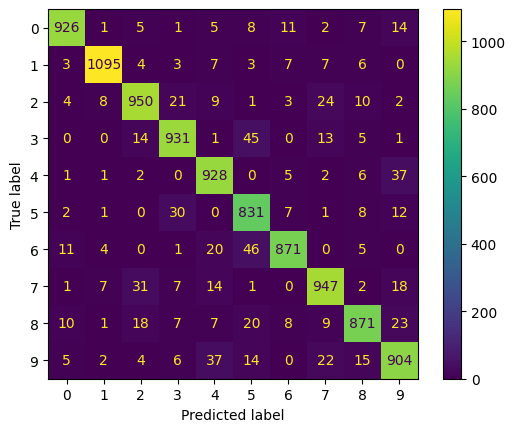

In [3]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Test accuracy on adversarial sample: %.2f%%" % (acc * 100))

y_hat = preds
y_test_arg = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_arg, y_hat)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test_arg, y_hat, average='macro')
accuracy = accuracy_score(y_test_arg, y_hat)
f1 = f1_score(y_test_arg, y_hat, average='weighted')
# auc = roc_auc_score(y_test_arg, cnn_model.predict(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
# print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

metrics = {
    "model" : "cnn",
    "attack_model" : "CarliniL2Method",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    # "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/MNIST/model.csv", mode='a', index=False)
